# Lax-Wendroff method for advection / periodic boundary conditions

[AMath 586, Spring Quarter 2016](http://faculty.washington.edu/rjl/classes/am586s2016/)

Sample program to solve the advection equation with the Lax-Wendroff method and show the results as an animation.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Use the JSAnimation package to convert a set of png files into an animation.  See https://github.com/jakevdp/JSAnimation for details.  We also use some utility functions in the module `JSAnimation_frametools.py` in this directory.  

If you want to use this in a different directory, e.g. `hw5`, then you should copy over the file `JSAnimation_frametools.py` so that it is available to import.  (Or put it somewhere on your `PYTHONPATH` if you want to use it more generally.)

In [2]:
import JSAnimation_frametools as J

In [3]:
plotdir = '_plots'  # to store png files for each figure

## Periodic boundary conditions

For explicit methods, we want to avoid implementing periodic boundary conditions via multiplication by a circulant matrix since there is no need to do linear algebra.  Instead it is convenient to simply implement a centered difference, for example, by something like `u[I+1] - u[I-1]` where `I` is a set of indices corresponding to the unknowns, e.g. $i = 0,~1,~2,~\ldots 5$ if $m=5, h=1/(m+1)$, so the periodic boundary conditions mean $u_6 = u_0$.  

At the boundaries we need to define `i+1` and `i-1` differently.  This can be accomplished by instead using `u[Ip1] - u[Im1]` where `Ip1` and `Im1` are defined using modular arithmetic.  This is illustrated in the next cell for a case with $m=5$.

In [4]:
I = array(range(6), dtype=int)
Im1 = mod(I-1,6)
Ip1 = mod(I+1,6)

print "Im1 = ",Im1
print "I   = ",I
print "Ip1 = ",Ip1

Im1 =  [5 0 1 2 3 4]
I   =  [0 1 2 3 4 5]
Ip1 =  [1 2 3 4 5 0]


In [5]:
def advection_LW_pbc(m, nsteps, nplot=None, verbose=False):
    """
    Solve u_t + au_x = 0  on [ax,bx] with periodic boundary conditions,
    using the Lax-Wendroff method with m interior points.
     
    Returns k, h, and the max-norm of the error
     
    """

    a = 2             # advection velocity
    
    ax = 0.
    bx = 1.
    tfinal = 1.                # final time

    def eta(x):
        """Initial conditions"""
        beta = 600.
        return exp(-beta*(x - 0.5)**2)

    def utrue(x,t):
        """
        True solution for comparison.
        For periodic BC's, we need the periodic extension of eta(x).
        Map x-a*t-ax back to interval of length bx-ax
        and then evaluate initial data at this point.
        """
        xat = ax + mod(x - a*t - ax, bx-ax)
        return eta(xat)


    h = (bx-ax)/float(m+1)     # h = delta x
    k = tfinal / float(nsteps) # time step
    nu = a*k/h                 # Courant number
    
    xgrid = linspace(ax, bx, m+2)
            
    I = array(range(m+1), dtype=int)   # indices of unknowns 0, 1, ..., m
    Im1 = mod(I-1, m+1)
    Ip1 = mod(I+1, m+1)

    if verbose:
        print "Will take %i time steps with k = %g, h = %g" % (nsteps,k,h)
        if nplot is not None:
            print "    and plot every %i time steps" % nplot

        print "The Courant number is nu = a*k/h = %g" % nu
        if abs(nu) > 1:
                print "*** Warning: the method is unstable!"

    
    # initial conditions:
    u0 = eta(xgrid)

    # initial data on fine grid for plotting:
    xfine = linspace(ax,bx,1001)
    ufine = utrue(xfine,0)

    if nplot is not None:
        
        # make plot directory for storing png files:
        J.make_plotdir(plotdir, clobber=True)  # ok to clobber if it already exists
        
        # plot initial data:
        plot(xgrid,u0,'b.-', label='computed')
        plot(xfine,ufine,'r', label='true')
        axis([ax,bx,-.2,1.2])
        legend()
        title('Initial data at time = 0')
    
        # Save this frame:
        J.save_frame(frameno=0, plotdir=plotdir, verbose=False)

        
    # main time-stepping loop:
    
    tn = 0.
    u = eta(xgrid)  # initial data

    for n in range(1,nsteps+1):
        tnp = tn + k   # = t_{n+1}
        
        # Lax-Wendroff:
        u[I] = u[I] - 0.5*nu*(u[Ip1] - u[Im1]) + \
                      0.5*nu**2 * (u[Im1] - 2*u[I] + u[Ip1])
            
        u[m+1] = u[0]  # for plotting

        # plot results at desired times:
        if nplot is not None:
            if mod(n,nplot)==0 or n==nsteps:
                uint = u[0:m+2]  # points on the interval (drop ghost cell on right)
                ufine = utrue(xfine,tnp)
                clf()
                plot(xgrid,u,'b.-', label='computed')
                plot(xfine,ufine,'r', label='true')
                axis([ax,bx,-.2,1.2])
                title('t = %9.5e  after %4i time steps with %5i grid points' \
                               % (tnp,n,m+1))
                    # Save this frame:
                J.save_frame(n, plotdir,verbose=False)
                
        tn = tnp   # for next time step
        close('all')  # close figure
        
    error = max(abs(u[0:m+2] - utrue(xgrid,tfinal)))
    return h,k,error


   h         dt          error      ratio  estimated order
0.020000  0.008333    0.46148773     nan         nan
0.010000  0.004167    0.30912523    1.49        0.58
0.005000  0.002083    0.13227926    2.34        1.22
0.002500  0.001042    0.03691866    3.58        1.84
0.001250  0.000521    0.00919066    4.02        2.01
0.000625  0.000260    0.00228720    4.02        2.01


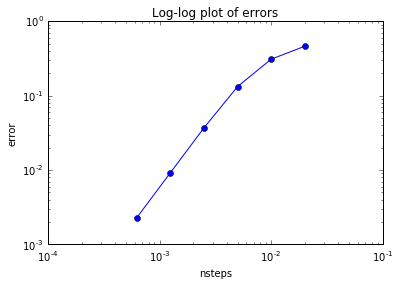

In [6]:
r_vals = array([1,2,4,8,16,32], dtype=int)
m_vals = 50*r_vals - 1
nsteps_vals = 120*r_vals
E = empty(len(nsteps_vals))

# print table header:
print "   h         dt          error      ratio  estimated order"

for j in range(len(r_vals)):
    m = nsteps_vals[j]/4 - 1
    h,dt,E[j] = advection_LW_pbc(m=m_vals[j], nsteps=nsteps_vals[j])
    if j>0:
        ratio = E[j-1] / E[j]
    else:
        ratio = nan
    p = log(ratio)/log(2)
    print "%8.6f  %8.6f  %12.8f    %4.2f        %4.2f" % (h, dt, E[j], ratio, p)

h_vals = 1./(m_vals + 1)
loglog(h_vals, E, '-o')
title('Log-log plot of errors')
xlabel('nsteps')
ylabel('error')
# savefig('LW_errors.png')

## Create an animation of the solution

First we solve the problem, storing png files of the plot every 10 steps:

In [7]:
advection_LW_pbc(m=99, nsteps=300, nplot=10, verbose=True)

Will take 300 time steps with k = 0.00333333, h = 0.01
    and plot every 10 time steps
The Courant number is nu = a*k/h = 0.666667
Figure files for each frame will be stored in  _plots


(0.01, 0.0033333333333333335, 0.40855754427003654)

Next we turn these into an animation:


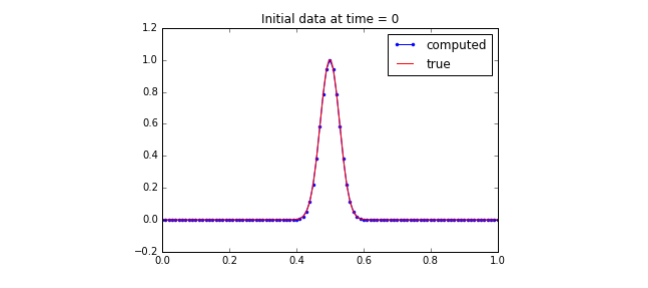
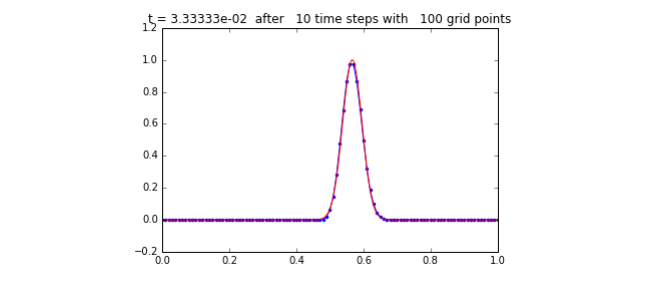
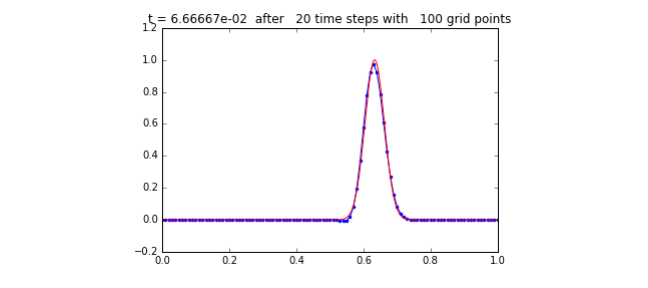
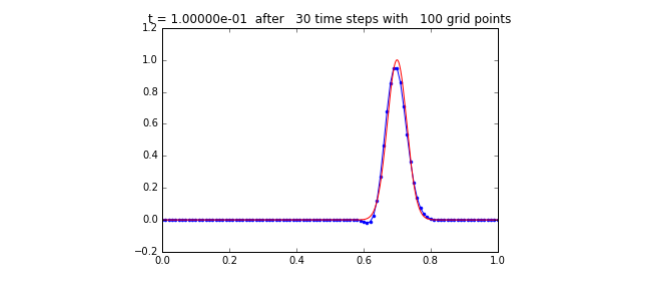
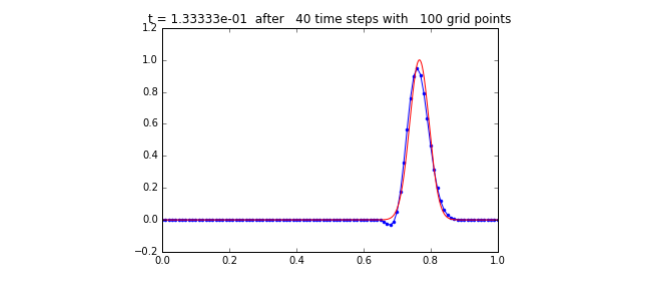
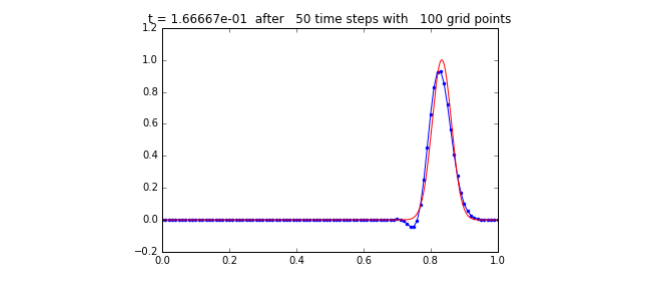
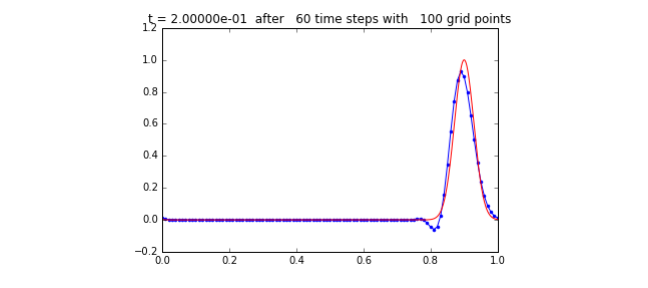
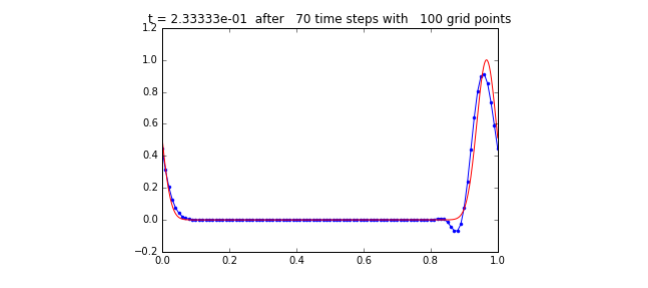
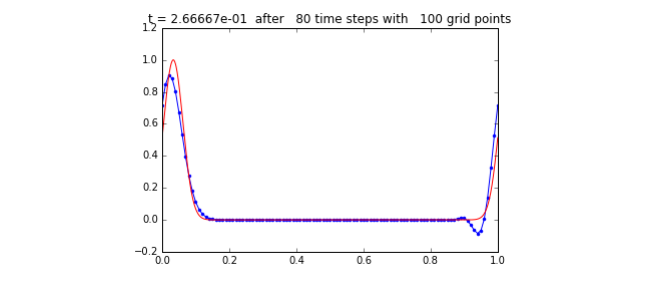
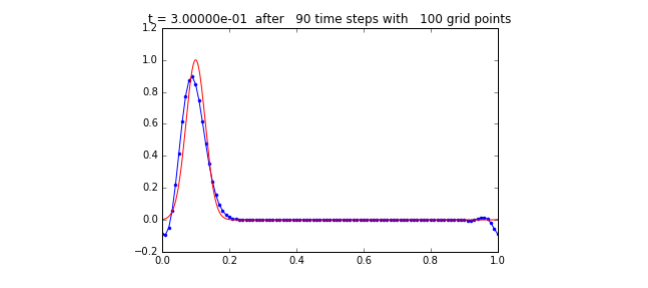
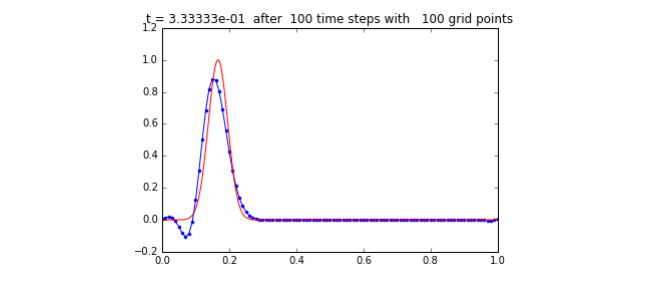
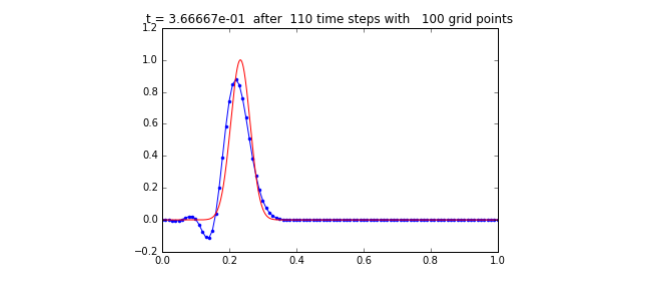
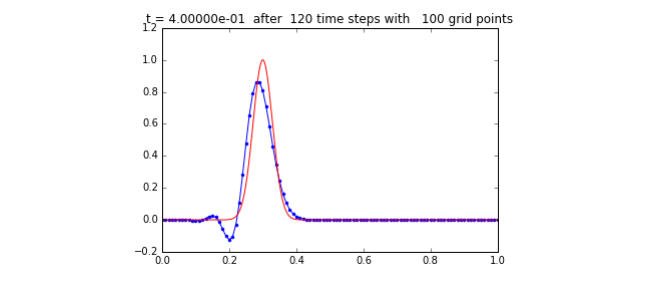
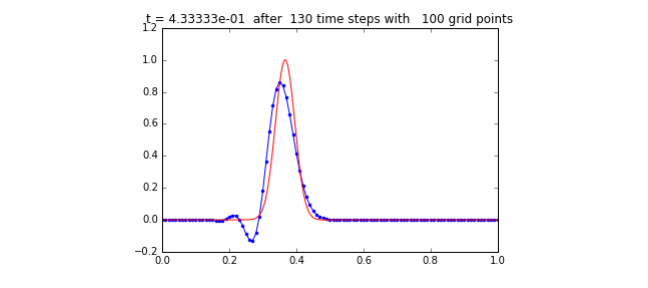
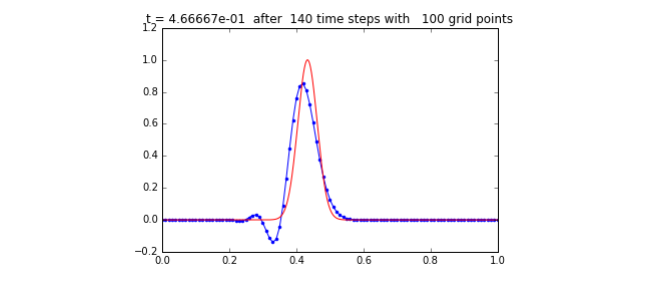
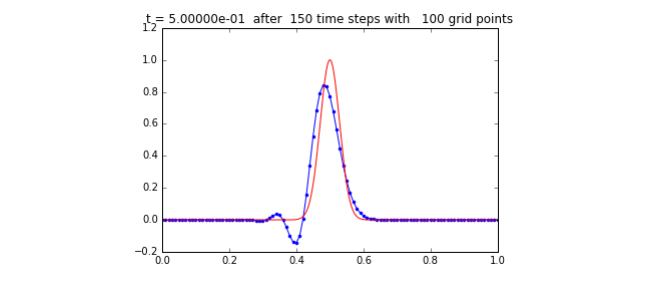
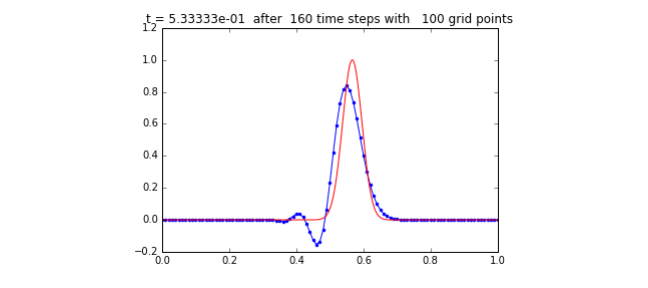
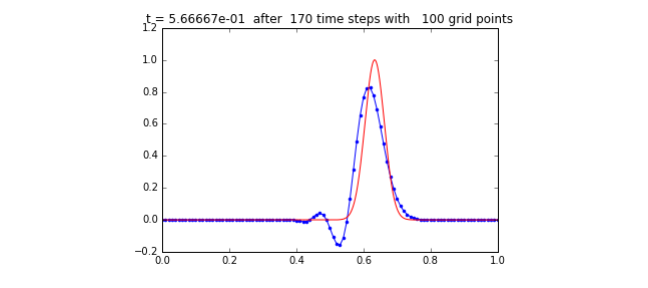
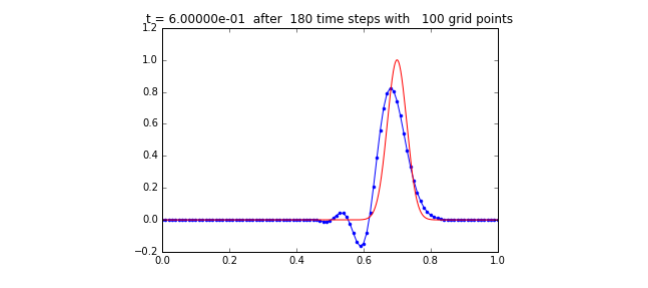
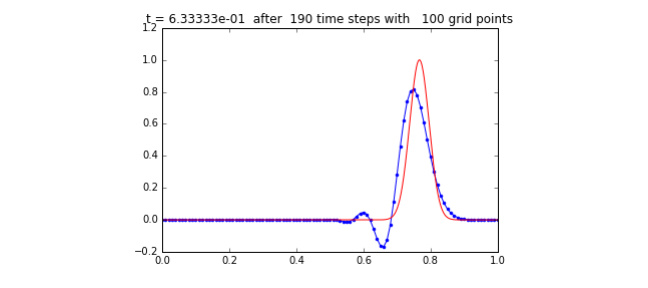
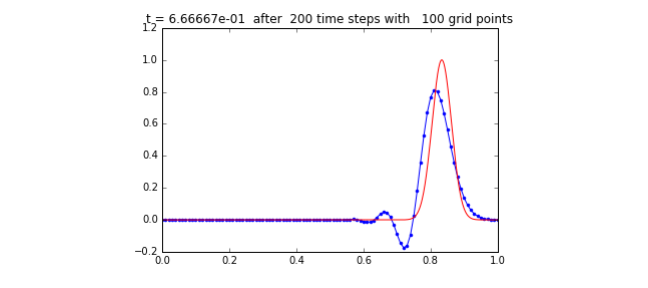
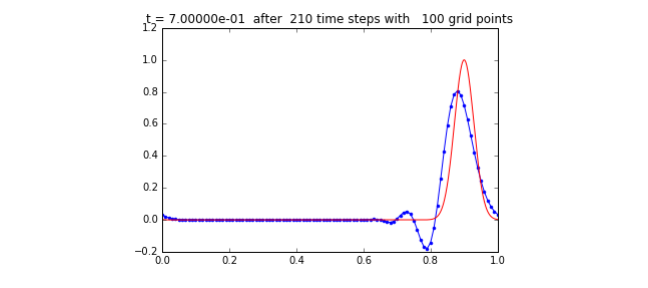
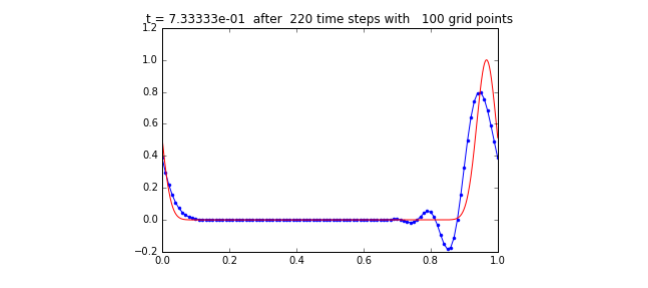
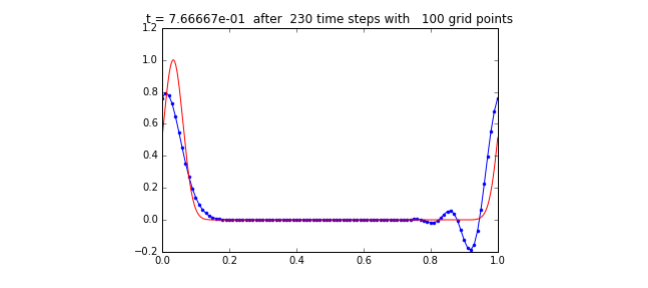
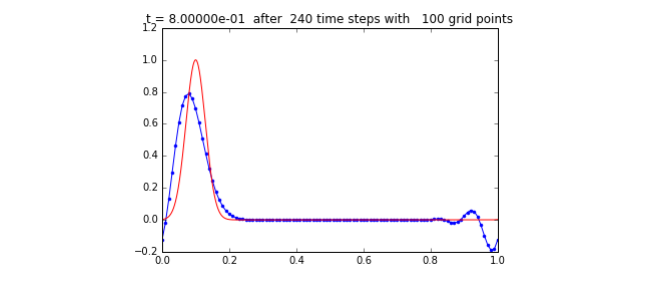
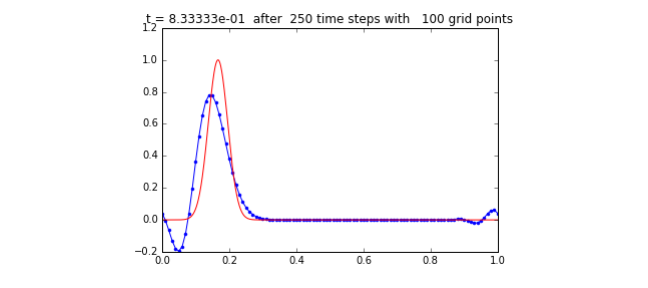
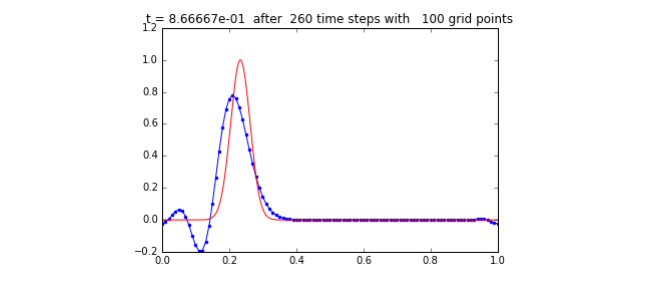
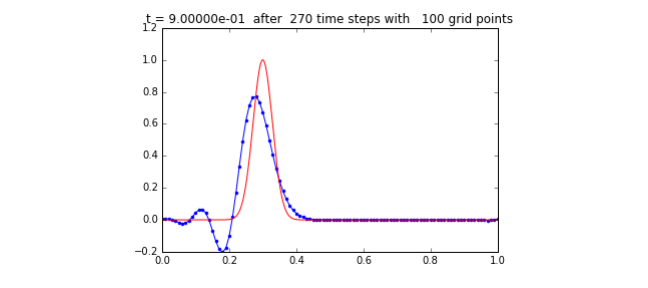
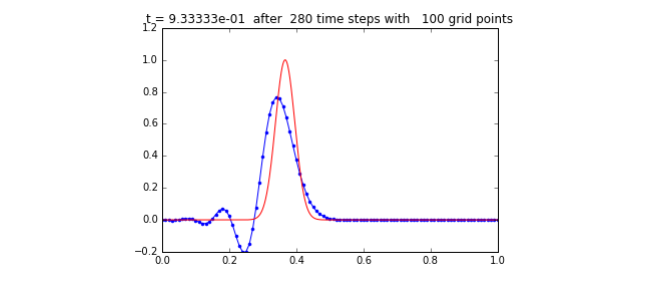
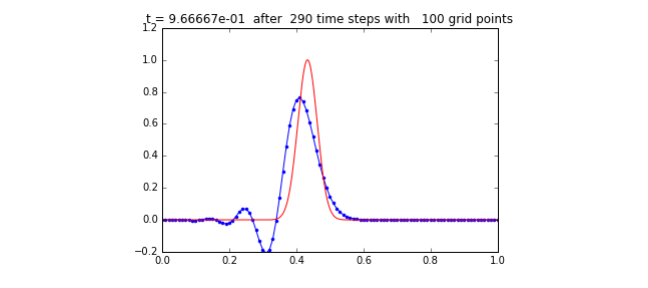
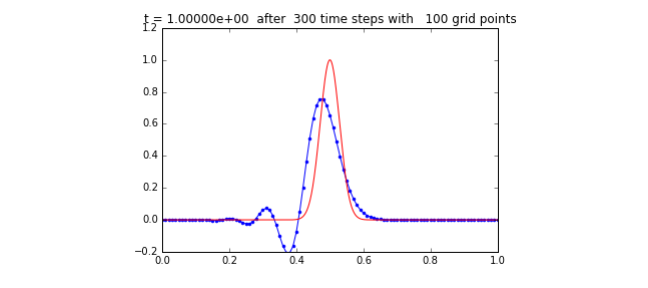

In [8]:
J.make_anim(plotdir, figsize=(9,4))